In [142]:
###############################################################################################################################################################################################
###### THIS CELL CONFIGURES THE NOTEBOOK, IMPORTS LIBRARIES AND DECLARE GLOBALS THAT ARE USED THROUGHOUT THIS NOTEBOOK. UPDATE ACCORDING DO YOUR CONFIGURATION + WHAT YOU WANT TO PLOT ########
###############################################################################################################################################################################################
import seaborn as sns                                                                                    
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import argparse
import os
from os import listdir
import copy
import pickle
import numpy as np
from scipy import stats
import glob
import os
import pandas as pd
import numpy as np

%matplotlib notebook

pd.set_option('display.max_columns', None)
pd.set_option('float_format', '{:f}'.format)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

rate = ''
exp_base_folder = os.path.join('/home/maxdml/experiments/', rate, '')
app_name = 'dmtr_http_srv'
client_name = 'rate_client'
stack_name = 'lwip'

In [177]:
##################### Traces description
# 1. CLT_PUSH_START - SENDING           Time between the scheduling of the request and its actual processing
# 2. CLT_PUSH_END - CLT_PUSH_START      Time to prepare the packet, send it to the NIC driver through rte_eth_tx_burst(), and free the dpdk mbuf
# 3. SRV_POP_START - CLT_PUSH_END       Time on the wire: item detected in the io queue's receive queue - client packet sent /!\ I think this can be negative if the server schedule's pop way before the client sends requests
# 4. SRV_POP_END - SRV_POP_START        Time to parse incoming packet + "waiting time" at the server's queue
# 5. NET_RECEIVE - SRV_POP_END          Time between message delivered to the application by dmtr_wait_any() and packet processed by the I/O queue
# 6. HTTP_DISPATCH - NET_RECEIVE        Time taken to select the HTTP recipient (either RR, or apply the filter, etc)
# 7. START_HTTP - HTTP_DISPATCH         Time spent in memory queue between network component and HTTP
# 8. END_HTTP - START_HTTP              Time spent performing HTTP processing
# 9. HTTP_DONE - END_HTTP               Time spent in memory queue between HTTP component and HTPP /!\ This include the "wait time" of dmtr_wait_any, as the same poll operates on both network sockets, and this memory queue
# 10. SRV_PUSH_START - HTTP_DONE        Time between the scheduling of the response and its actual processing
# 11. SRV_PUSH_END - SRV_PUSH_START     Time spent preparing the packet and sending it to the wire (identical to #2)
# 12. CLT_POP_START - SRV_PUSH_END      Time spent on the wire /!\ I think this can be negative as the client schedules the read as soon as it as sent the request
# 13. CLT_POP_END - CLT_POP_START       Time spent processing an incoming network packet (includes wait time) (identical to #4)
# 14. COMPLETED - CLT_POP_END           Time ellapsed between the reponse being delivered to the client by dmtr_wait_any(), and the response's being fully processed by the I/O queue

TRACE_ORDER = [
    'SENDING',
    'CLT_PUSH_START',
#     'CLT_PUSH_END',
#     'SRV_POP_START',
    'SRV_POP_END',
    'NET_RECEIVE',
    'HTTP_DISPATCH',
    'START_HTTP',
    'END_HTTP',
    'HTTP_DONE',
    'SRV_PUSH_START',
#     'SRV_PUSH_END',
#     'CLT_POP_START',
    'CLT_POP_END',
    'COMPLETED'
]

CLT_TRACE_ORDER = [
    'SENDING',
    'READING',
    'COMPLETE'
]

def read_tokens(trace_dir, exclude_first = 5):
    #REQ_ID	SENDING	READING	COMPLETED	PUSH_TOKEN	POP_TOKEN)
    files = glob.glob(os.path.join(trace_dir, '*traces*'))
    files = list(filter(lambda x: not ('POP' in x or 'PUSH' in x), files))
    if len(files) > 1:
        raise Exception("Too many files")
    df = pd.read_csv(files[0], sep='\t')
    
    min_time = df[df.columns[1]].min()
    df = df[df[df.columns[1]] > min_time + exclude_first * 1e9]
    return df

def read_traces(trace_dir, label):
    files = glob.glob(os.path.join(trace_dir, '*%s-traces' % label))
    if len(files) > 1:
        raise Exception("Too many files")
    df = pd.read_csv(files[0], sep='\t')
    return df

def merge_trace(token_df, trace_df, token_label, col_label):
    trace_df = trace_df[['%s_TOKEN' % token_label, 'TIME']]
    df = pd.merge(token_df, trace_df, on='%s_TOKEN' % token_label)
#     return df
    return df.rename(columns={'TIME': col_label})

def merge_traces(token_df, trace_df, token_label, col_label):
    start_df = trace_df[trace_df.START]
    stop_df = trace_df[~trace_df.START]

    df = merge_trace(token_df, start_df, token_label, '%s_%s_START' % (col_label, token_label))
    df = merge_trace(df, stop_df, token_label, '%s_%s_END' % (col_label, token_label))
    return df

col_labels = {client_name: 'CLT', app_name: 'SRV'}
token_labels = {client_name: 'rate_client', app_name: ''}

def order_cols(df, subtract_root = True):
    col_order = list(filter(lambda x: x in df.columns, TRACE_ORDER, ))
    df = df[['REQ_ID'] +col_order].set_index('REQ_ID')
    
    if subtract_root:
        df[col_order] = df[col_order].apply(lambda x: x - df[col_order[0]])
    return df

def read_profiling_node(base_dir, experiment, node_label):
    client_dir = os.path.join(base_dir, experiment, node_label)
    token_df = read_tokens(client_dir)
    push_df = read_traces(client_dir, 'PUSH')
    pop_df = read_traces(client_dir, 'POP')
    
    df = merge_traces(token_df, push_df, 'PUSH', col_labels[node_label])
    df = merge_traces(df, pop_df, 'POP', col_labels[node_label])
    
    return order_cols(df)
    
CLIENT_RCV = 'CLT_POP_END'
CLIENT_SND = 'CLT_PUSH_START'
    
def read_merged_profiling(base_dir, experiment):
    client_df = read_profiling_node(base_dir, experiment, client_name)
    server_df = read_profiling_node(base_dir, experiment, app_name)
    
    server_cols = server_df.columns
    client_cols = client_df.columns
    
    df = client_df.join(server_df)
    
    offset = df[CLIENT_SND]
    
    df[server_cols] = df[server_cols].apply(lambda x: x + offset)
    
    offset =( df[CLIENT_RCV] - df[server_cols[-1]]) / 2
    
    df[server_cols] = df[server_cols].apply(lambda x: x + offset)
    
    
    return order_cols(df.reset_index())

In [140]:
COLORS = ["#700f00",
"#013fb0",
"#cbcd11",
"#6b3a7d",
"#ff392e",
"#008eb2",
"#ff8da5",
"#000000",
"#458f00",
"#AAAAAA",
"#123456",
"#7192F1",
"#013fb0",
'#777777',
'#BBBBBB'
]

def stacked_plot(df, full_sep=False):
    columns = df.columns
    print(columns)
    bottom = 0
    cols_so_far = []
    for prev_col, next_col, color in zip(columns, columns[1:], COLORS):
        if not full_sep:
            bottom = df[prev_col]
        plt.bar(df.index, df[next_col] - df[prev_col], 1, bottom=bottom, color=color, label=prev_col)
        if full_sep:
            bottom = (bottom + df[next_col]- df[prev_col]).max()

In [159]:
def plot_stacked_sample(df, sample_size=100, full_sep=False):
    df = df.sort_values(df.columns[-1])

    lowest = df.iloc[:sample_size]
    highest = df.iloc[-sample_size:]
    middlest = df.iloc[int(len(df) / 2 - sample_size / 2): int(len(df) / 2 + sample_size / 2)]

    plt.figure(figsize=(9.5, 4))
    ax1 = plt.subplot(131)
    stacked_plot(lowest.reset_index(drop=True), full_sep)
    ax2 = plt.subplot(132)
    stacked_plot(middlest.reset_index(drop=True), full_sep)
    plt.subplot(133)
    stacked_plot(highest.reset_index(drop=True), full_sep)
    plt.tight_layout()
    plt.subplots_adjust(top=.8)
    plt.sca(ax2)

    plt.legend(loc='lower center', bbox_to_anchor=(.5, 1), ncol=5)

<IPython.core.display.Javascript object>


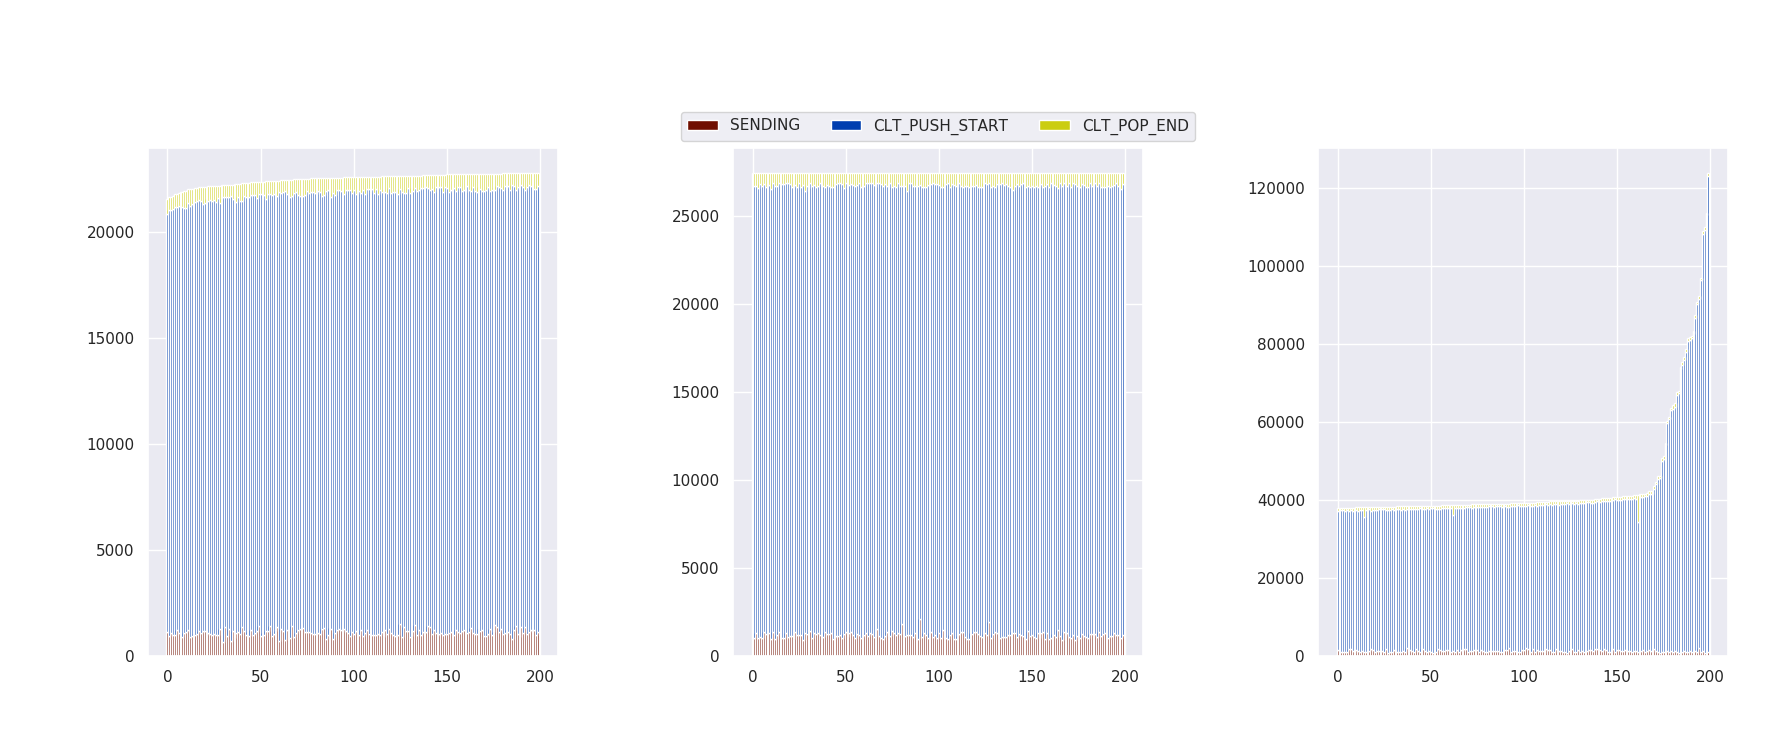

Index(['SENDING', 'CLT_PUSH_START', 'CLT_POP_END', 'COMPLETED'], dtype='object')
Index(['SENDING', 'CLT_PUSH_START', 'CLT_POP_END', 'COMPLETED'], dtype='object')
Index(['SENDING', 'CLT_PUSH_START', 'CLT_POP_END', 'COMPLETED'], dtype='object')


In [174]:
df = read_profiling_node(exp_base_folder, '8oneregex2', client_name)
plot_stacked_sample(df, 200)

<IPython.core.display.Javascript object>


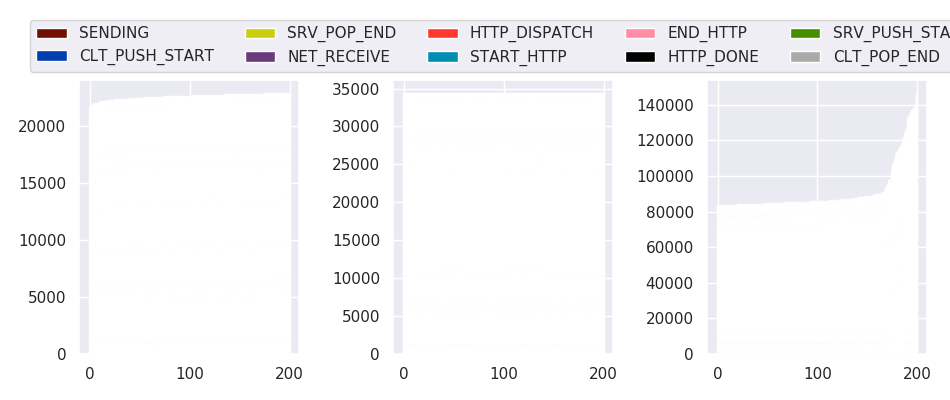

Index(['SENDING', 'CLT_PUSH_START', 'SRV_POP_END', 'NET_RECEIVE',
       'HTTP_DISPATCH', 'START_HTTP', 'END_HTTP', 'HTTP_DONE',
       'SRV_PUSH_START', 'CLT_POP_END', 'COMPLETED'],
      dtype='object')
Index(['SENDING', 'CLT_PUSH_START', 'SRV_POP_END', 'NET_RECEIVE',
       'HTTP_DISPATCH', 'START_HTTP', 'END_HTTP', 'HTTP_DONE',
       'SRV_PUSH_START', 'CLT_POP_END', 'COMPLETED'],
      dtype='object')
Index(['SENDING', 'CLT_PUSH_START', 'SRV_POP_END', 'NET_RECEIVE',
       'HTTP_DISPATCH', 'START_HTTP', 'END_HTTP', 'HTTP_DONE',
       'SRV_PUSH_START', 'CLT_POP_END', 'COMPLETED'],
      dtype='object')


In [176]:
df = read_merged_profiling(exp_base_folder, '852kuris_filter1')
plot_stacked_sample(df, 200)

In [ ]:
df = read_merged_profiling(exp_base_folder, '852kuris2')
plot_stacked_sample(df, 200)

<IPython.core.display.Javascript object>


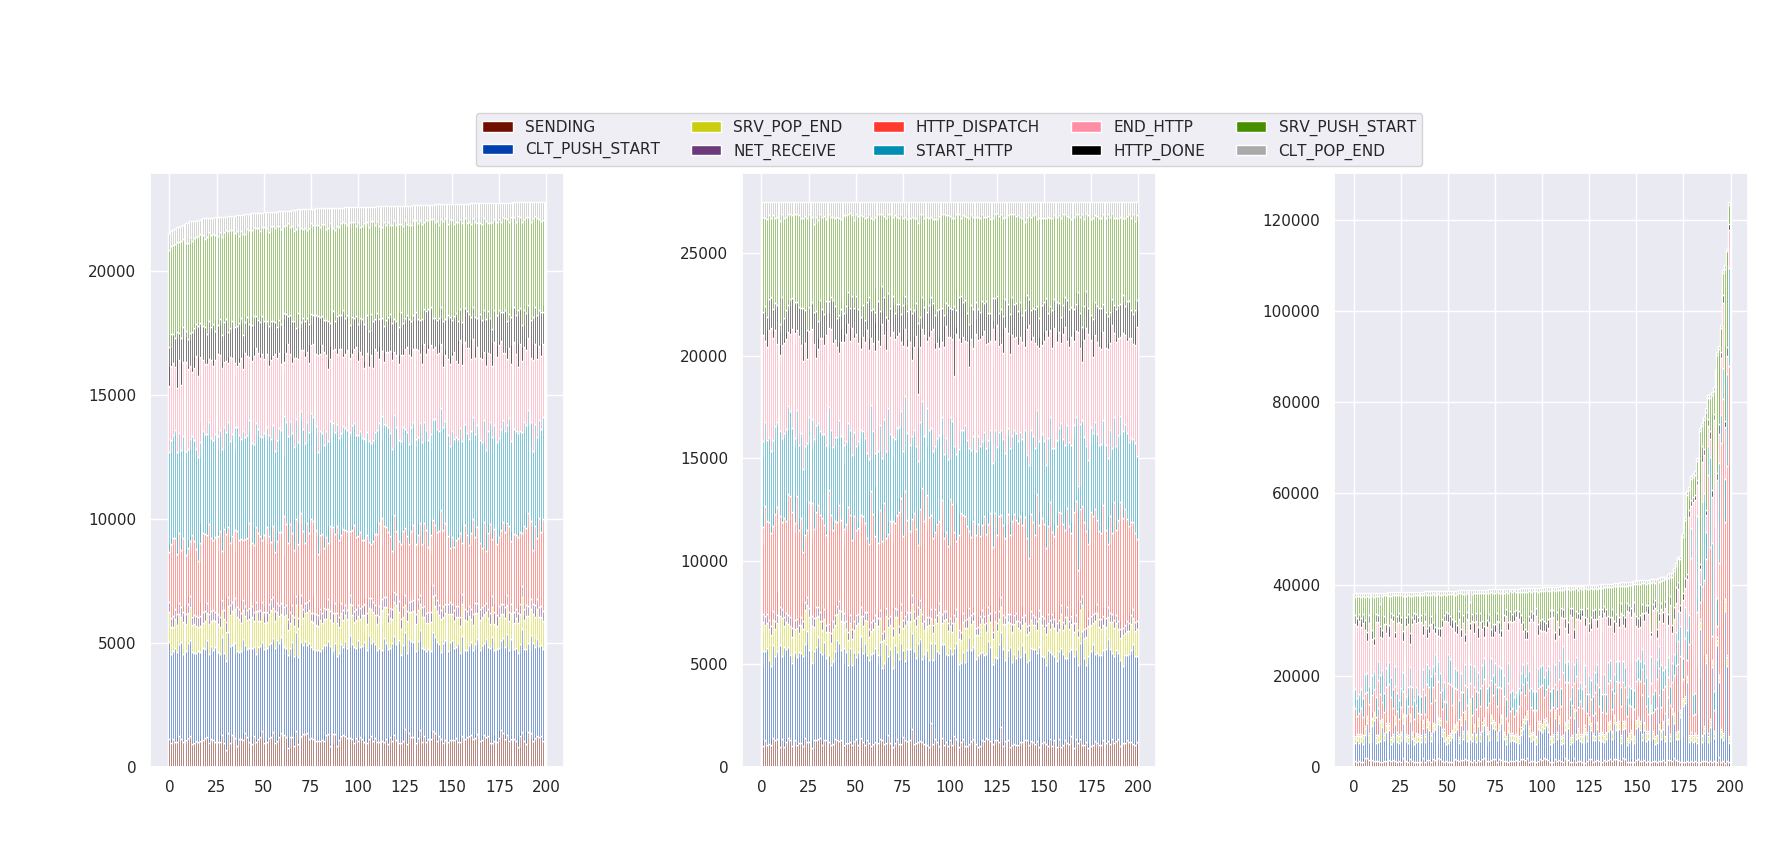

Index(['SENDING', 'CLT_PUSH_START', 'SRV_POP_END', 'NET_RECEIVE',
       'HTTP_DISPATCH', 'START_HTTP', 'END_HTTP', 'HTTP_DONE',
       'SRV_PUSH_START', 'CLT_POP_END', 'COMPLETED'],
      dtype='object')
Index(['SENDING', 'CLT_PUSH_START', 'SRV_POP_END', 'NET_RECEIVE',
       'HTTP_DISPATCH', 'START_HTTP', 'END_HTTP', 'HTTP_DONE',
       'SRV_PUSH_START', 'CLT_POP_END', 'COMPLETED'],
      dtype='object')
Index(['SENDING', 'CLT_PUSH_START', 'SRV_POP_END', 'NET_RECEIVE',
       'HTTP_DISPATCH', 'START_HTTP', 'END_HTTP', 'HTTP_DONE',
       'SRV_PUSH_START', 'CLT_POP_END', 'COMPLETED'],
      dtype='object')


In [173]:
df = read_merged_profiling(exp_base_folder, '8oneregex2')
plot_stacked_sample(df, 200)

In [ ]:
exps = ['test']
exp_data = {}
for exp in exps:
    exp_data[exp] = pd.DataFrame()
    # First fetch server traces
    filename = exp +  '-traces-1' #FIXME add support for multiple network components
    serv_traces_f = os.path.join(exp_base_folder, exp, app_name, filename)
    server_traces = pd.read_csv(serv_traces_f, delimiter='\t')
#     print(server_traces)
    
    # Merge with demeter token traces
    filename_pattern = '-pop-traces'
    folderpath = os.path.join(exp_base_folder, exp, app_name)
    # Pop files
    pop_files = [os.path.join(folderpath, f) for f in listdir(folderpath) if os.path.isfile(os.path.join(folderpath, f)) and f.endswith(filename_pattern)]
    df = pd.read_csv(pop_files[0], delimiter='\t')
    server_df = pd.merge(server_traces, df, on='POP_TOKEN')
    server_df['SRV_POP_START'] = server_df[server_df.START == True].TIME
    server_df['SRV_POP_END'] = server_df[server_df.START == False].TIME
    server_df = server_df.groupby(['REQ_ID']).first().drop(['TIME', 'START', 'POP_TOKEN'], axis=1).reset_index() # get the first/last non-null value for each column within the group
    # Push
    filename_pattern = '-push-traces'
    push_files = [os.path.join(folderpath, f) for f in listdir(folderpath) if os.path.isfile(os.path.join(folderpath, f)) and f.endswith(filename_pattern)]
    df = pd.read_csv(push_files[0], delimiter='\t') 
    server_df = pd.merge(server_df, df, on='PUSH_TOKEN')
    server_df['SRV_PUSH_START'] = server_df[server_df.START == True].TIME
    server_df['SRV_PUSH_END'] = server_df[server_df.START == False].TIME
    server_df = server_df.groupby(['REQ_ID']).first().drop(['TIME', 'START', 'PUSH_TOKEN'], axis=1).reset_index() # get the first/last non-null value for each column within the group
        
    # Then idem for client traces
    filename = exp + '_traces'
    client_traces_f = os.path.join(exp_base_folder, exp, client_name, filename)
    client_traces = pd.read_csv(client_traces_f, delimiter='\t')
    
    # Merge with demeter token traces
    filename_pattern = '-pop-traces'
    folderpath = os.path.join(exp_base_folder, exp, client_name)
    # Pop files
    pop_files = [os.path.join(folderpath, f) for f in listdir(folderpath) if os.path.isfile(os.path.join(folderpath, f)) and f.endswith(filename_pattern)]
    df = pd.read_csv(pop_files[0], delimiter='\t')
    client_df = pd.merge(client_traces, df, on='POP_TOKEN')
    client_df['CLT_POP_START'] = client_df[client_df.START == True].TIME
    client_df['CLT_POP_END'] = client_df[client_df.START == False].TIME
    client_df = client_df.groupby(['REQ_ID']).first().drop(['TIME', 'START', 'POP_TOKEN'], axis=1).reset_index() # get the first/last non-null value for each column within the group
    # Push
    filename_pattern = '-push-traces'
    push_files = [os.path.join(folderpath, f) for f in listdir(folderpath) if os.path.isfile(os.path.join(folderpath, f)) and f.endswith(filename_pattern)]
    df = pd.read_csv(push_files[0], delimiter='\t') 
    client_df = pd.merge(client_df, df, on='PUSH_TOKEN')
    client_df['CLT_PUSH_START'] = client_df[client_df.START == True].TIME
    client_df['CLT_PUSH_END'] = client_df[client_df.START == False].TIME
    client_df = client_df.groupby(['REQ_ID']).first().drop(['TIME', 'START', 'PUSH_TOKEN'], axis=1).reset_index() # get the first/last non-null value for each column within the group
    
    # Merge both server and client
    cols = ['SENDING', 'CLT_PUSH_START', 'CLT_PUSH_END', 'SRV_POP_START', 'SRV_POP_END', 'NET_RECEIVE', 'HTTP_DISPATCH', 'START_HTTP', 'END_HTTP', 'HTTP_DONE', 'SRV_PUSH_START', 'SRV_PUSH_END', 'CLT_POP_START', 'CLT_POP_END', 'COMPLETED']
    full_df = pd.merge(server_df, client_df, on='REQ_ID').astype('int64')
    full_df = full_df[cols]
    full_df = full_df.diff(axis=1)
    full_df.drop(['SENDING', 'SRV_POP_START', 'CLT_POP_START'], inplace=True, axis=1) #We remove the first and cross machine columns
    
    # Now we take percentiles for columns
    percentiles = [50, 75, 90, 95, 99]
    median = full_df.quantile(q=.5, axis=0)
    seventy_five = full_df.quantile(q=.75, axis=0)
    ninety = full_df.quantile(q=.9, axis=0)
    ninety_five = full_df.quantile(q=.95, axis=0)
    ninety_nine = full_df.quantile(q=.99, axis=0)
    pctl_dfs = [median, seventy_five, ninety, ninety_five, ninety_nine]

<IPython.core.display.Javascript object>


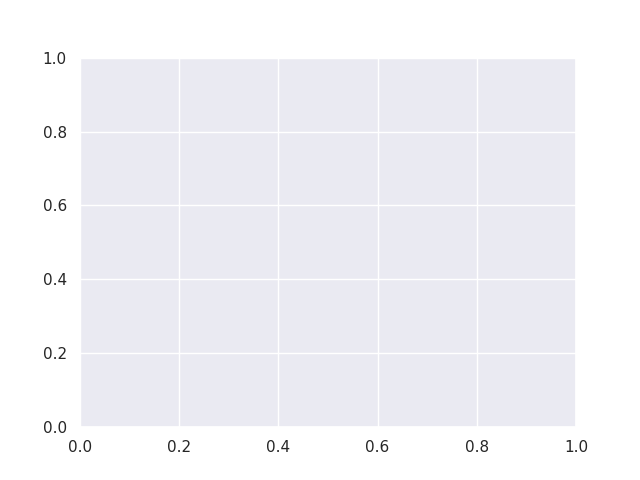

ValueError: Invalid RGBA argument: 'D'

In [136]:
#TODO: add std to each stacked bar


colors = ['D617A9', '59DB5E']
ind = np.arange(len(percentiles))
width = .35
bars = []
prev_values = None
for i, c in enumerate(full_df.columns):
    values = [pctl_dfs[j][c] for j in range(len(percentiles))]
    if i == 0:
        b = plt.bar(ind, values, width, color=colors[i%1])
    else:
        b = plt.bar(ind, values, width, bottom=prev_values, color=colors[i%1])
    prev_values = values
    bars.extend(b)

plt.ylabel('Latency (ns)')
plt.title('Request processing execution times')
plt.xticks(ind, ('median', '75th', '90th', '95th', '99th'))
legend_bars = (bars[i] for i in range(len(full_df.columns)))
legend_labels = set(full_df.columns)
plt.legend(legend_bars, legend_labels)

plt.show()